In [1]:
from functools import partial

import contextily as cx
import geodatasets
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
import pandas as pd
from IPython.display import Image
from pysgn import geo_erdos_renyi_network, graph_to_gdf, sample_points
from shapely.geometry import Point

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

# Sample Point Geometries

`sample_points` generates point geometries for node synthesis inside a spatial domain.

By default, candidate points are sampled **uniformly** over the final domain, then filtered with geometric rejection when needed.

- If you provide only `bbox`, points are sampled uniformly in that rectangle.
- If you provide only `polygon`, points are sampled in the polygon area.
- If both are provided, the effective domain is their intersection.

This means the default sampling density is constant over the final domain (that is, no distance-decay or preference weighting is applied unless you provide a custom sampler).

## Default Uniform Sampling in a Bounding Box

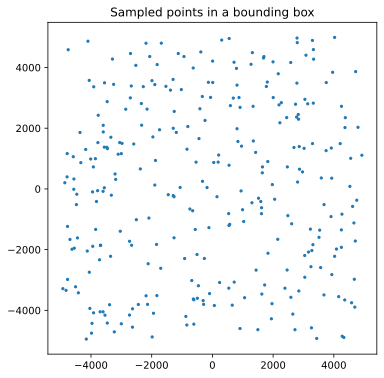

,geometry
0,POINT (2739.56 2789.964)
1,POINT (-611.216 -3654.478)
2,POINT (3585.979 360.68)
3,POINT (1973.68 142.229)
4,POINT (-4058.227 3575.721)


In [ ]:
points_gdf = sample_points(
    300,
    bbox=(-5000, -5000, 5000, 5000),
    random_state=42,
)

_, ax = plt.subplots(1, 1, figsize=(6, 6))
points_gdf.plot(ax=ax, color="tab:blue", markersize=5)
ax.set_title("Sampled points in a bounding box")
ax.set_aspect("equal")
plt.show()

points_gdf.head()

## Uniform Sampling Inside a Polygon

Instead of using a boundbox, you can pass a polygon domain directly. Here we load Chicago community polygons from `geodatasets`, project them to a planar CRS, and sample points within the unioned polygon geometry.

The output CRS is set explicitly from the polygon layer.

In [3]:
communities = gpd.read_file(geodatasets.get_path("geoda.chicago_commpop")).to_crs(
    "EPSG:26971"
)
polygon_domain = communities.geometry.union_all()

points_gdf_in_polygon = sample_points(
    300,
    polygon=polygon_domain,
    crs=communities.crs,
    random_state=42,
)
points_gdf_in_polygon.head()

,geometry
0,POINT (356823.43 574469.913)
1,POINT (335851.684 588888.713)
2,POINT (359040.645 569047.015)
3,POINT (359907.224 579733.528)
4,POINT (354963.24 562642.025)


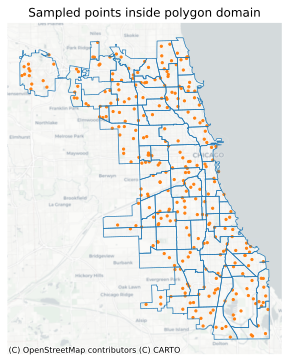

In [4]:
_, ax = plt.subplots(1, 1, figsize=(6, 6))
communities.boundary.plot(ax=ax, color="tab:blue", linewidth=0.7)
points_gdf_in_polygon.plot(ax=ax, color="tab:orange", markersize=5)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=communities.crs)
ax.set_title("Sampled points inside polygon domain")
ax.set_aspect("equal")
ax.axis("off")
plt.show()

## Custom Sampling with a Parameterized Multivariate Normal

For concise custom distributions, you can define a generic sampler and bind parameters with `functools.partial`.

The example below uses NumPy's multivariate normal sampler (`rng.multivariate_normal`) with fixed `mean` and `cov`.

`sample_points` still enforces the target domain via rejection, so any candidates outside the domain are discarded until `n` accepted points are collected (or `max_attempts` is reached).

In [5]:
def mvn_sampler(rng, k, *, mean, cov):
    return rng.multivariate_normal(mean=mean, cov=cov, size=k)


sampler = partial(
    mvn_sampler,
    mean=[500, -1000],
    cov=[[1200**2, 250_000], [250_000, 700**2]],
)

custom_points_gdf = sample_points(
    300,
    bbox=(-5000, -5000, 5000, 5000),
    sampler=sampler,
    random_state=42,
)

custom_points_gdf.head()

,geometry
0,POINT (300.731 -1750.261)
1,POINT (-540.447 -623.077)
2,POINT (3025.532 -1253.726)
3,POINT (397.551 -1238.484)
4,POINT (653.893 -1536.987)


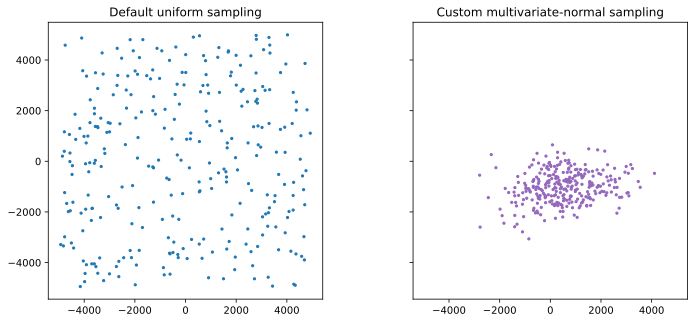

In [6]:
_, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
points_gdf.plot(ax=ax[0], color="tab:blue", markersize=5)
ax[0].set_title("Default uniform sampling")
ax[0].set_aspect("equal")

custom_points_gdf.plot(ax=ax[1], color="tab:purple", markersize=5)
ax[1].set_title("Custom multivariate-normal sampling")
ax[1].set_aspect("equal")

plt.show()

# Convert a Graph Back to GeoDataFrames

`graph_to_gdf` reconstructs node and edge layers from a geospatial NetworkX graph. This is useful when you want to move from graph analysis back to geospatial workflows for plotting or exporting data.

Node attributes can be preserved through the full workflow:

1. add attributes to the input GeoDataFrame,
2. pass `node_attributes` when creating the graph,
3. convert back with `graph_to_gdf` and verify the exported columns.

If you plan to export layers to GIS formats (for example GeoPackage), preserving node attributes at graph-construction time ensures they remain available in the exported node table.

In [7]:
points_with_attrs_gdf = points_gdf.copy()
points_with_attrs_gdf["zone"] = np.where(
    points_with_attrs_gdf.geometry.x >= 0,
    "east",
    "west",
)
points_with_attrs_gdf["weight"] = np.round(
    np.abs(points_with_attrs_gdf.geometry.x) / 1000,
    2,
)

# Preserve selected node attributes when creating the network
graph = geo_erdos_renyi_network(
    points_with_attrs_gdf,
    node_attributes=["zone", "weight"],
)

# Convert graph back to geospatial tables
nodes_gdf, edges_gdf = graph_to_gdf(graph)

After exporting with `graph_to_gdf`, the selected node attributes are present in `nodes_gdf`:

In [8]:
print(f"nodes_gdf.shape: {nodes_gdf.shape}")
nodes_gdf.head()

nodes_gdf.shape: (300, 3)


,zone,weight,geometry
0,east,2.74,POINT (2739.56 2789.964)
24,east,2.78,POINT (2783.835 3485.605)
30,east,2.45,POINT (2447.622 2348.932)
42,east,2.00,POINT (2002.651 3008.842)
44,east,3.32,POINT (3322.598 2826.241)


In [9]:
print(f"edges_gdf.shape: {edges_gdf.shape}")
edges_gdf.head()

edges_gdf.shape: (2343, 4)


,source,target,length,geometry
0,0,24,7263.506463,"LINESTRING (2739.56 2789.964, 2783.835 3485.605)"
1,0,30,2572.516557,"LINESTRING (2739.56 2789.964, 2447.622 2348.932)"
2,0,42,2756.278701,"LINESTRING (2739.56 2789.964, 2002.651 3008.842)"
3,0,44,6843.049295,"LINESTRING (2739.56 2789.964, 3322.598 2826.241)"
4,0,45,3750.331101,"LINESTRING (2739.56 2789.964, 3047.644 2951.148)"


# Performance

We measure and visualize the time and space complexities of our synthetic network models as they scale with different numbers of nodes. This helps understand how computational resources scale with network size.

Note that performance can vary significantly depending on the specific parameters (e.g., distance decay exponent, scaling factor, `k`, `m`, and so on) used in your network models. Here we set `m=10` for geospatial Barabási-Albert network and `k=10`, `p=0.1` for geospatial Watts-Strogatz network, with all other parameters using their default values.

**Hardware Specifications**

The results are based on the hardware this notebook is currently running on, with Python 3.13.2:

- CPU: 2.6 GHz 6-Core Intel Core i7
- Memory: 16 GB 2667 MHz DDR4
- Operating System: macOS Sequoia 15.3.2

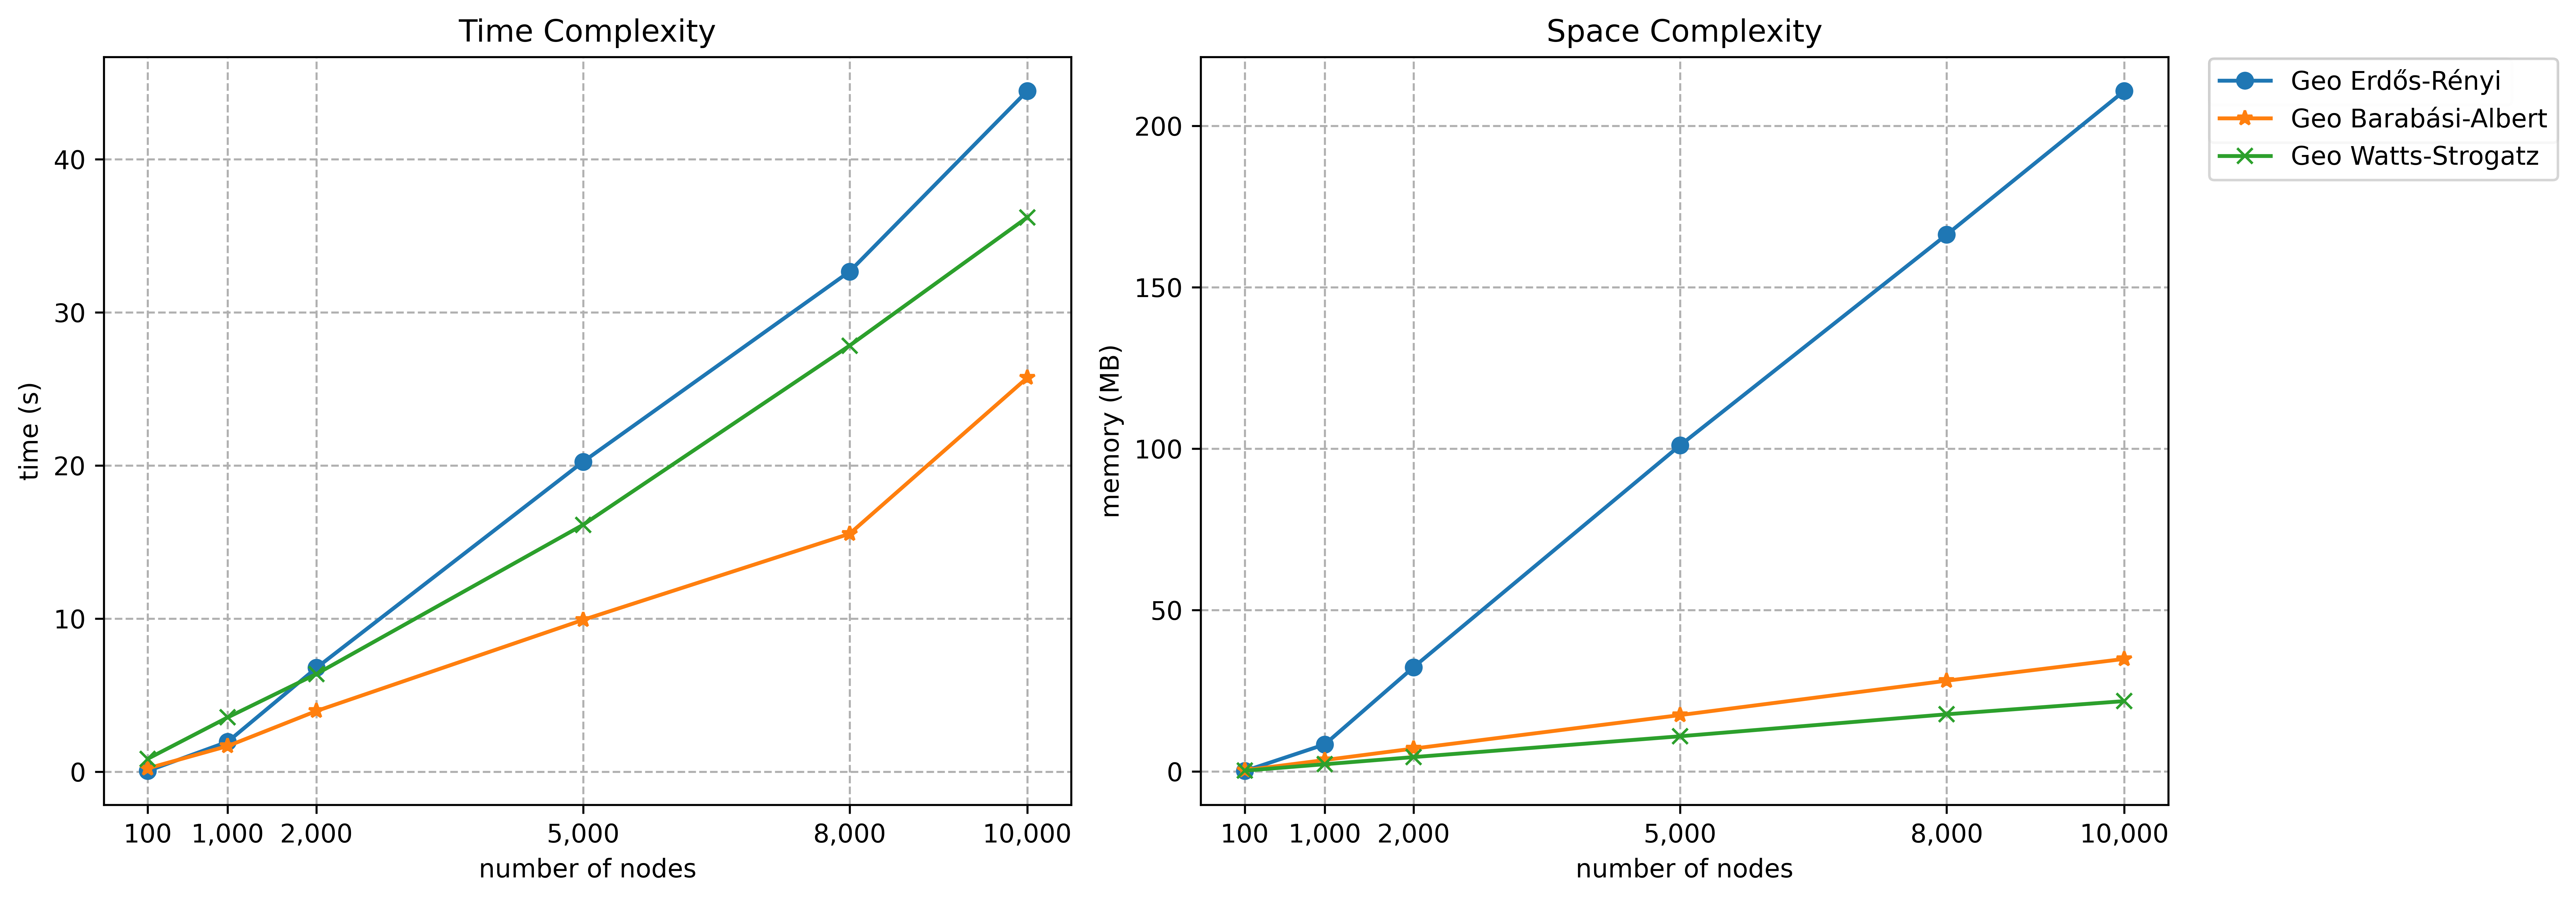

In [10]:
Image("perf.png")

You can run the code below in a code cell to test the performance on your own hardware. This gives you a personalized estimate of how the algorithms will perform in your environment.

```python
import time
import tracemalloc

from matplotlib import ticker

num_points = 10000
x_coords = np.random.uniform(-5000, 5000, num_points)
y_coords = np.random.uniform(-5000, 5000, num_points)
points = [Point(x, y) for x, y in zip(x_coords, y_coords)]
points_gdf = gpd.GeoDataFrame(pd.DataFrame({"geometry": points}), crs="EPSG:3857")
gdf_list = [
    points_gdf.sample(n=n, replace=False, random_state=42)
    for n in [100, 1000, 2000, 5000, 8000, 10000]
]

perf = {
    "num_nodes": [],
    "time_s": [],
    "memory_mb": [],
    "model": [],
}
for gdf in gdf_list:
    for (
        model,
        func,
        params,
    ) in zip(
        ["Geo Erdős-Rényi", "Geo Barabási-Albert", "Geo Watts-Strogatz"],
        [
            geo_erdos_renyi_network,
            geo_barabasi_albert_network,
            geo_watts_strogatz_network,
        ],
        [{}, {"m": 10}, {"k": 10, "p": 0.1}],
    ):
        perf["num_nodes"].append(len(gdf))
        perf["model"].append(model)
        tracemalloc.start()
        start_time = time.perf_counter()
        _ = func(gdf, **params)
        elapsed = time.perf_counter() - start_time
        _, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        perf["time_s"].append(elapsed)
        perf["memory_mb"].append(peak / 1024**2)

perf_df = pd.DataFrame(perf)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for color, model, marker in zip(
    ["tab:blue", "tab:orange", "tab:green"],
    ["Geo Erdős-Rényi", "Geo Barabási-Albert", "Geo Watts-Strogatz"],
    ["o", "*", "x"],
):
    ax[0].plot(
        perf_df.loc[perf_df["model"] == model, "num_nodes"],
        perf_df.loc[perf_df["model"] == model, "time_s"],
        color=color,
        marker=marker,
        label=model,
    )
    ax[0].grid(True, linestyle="--")
    ax[1].plot(
        perf_df.loc[perf_df["model"] == model, "num_nodes"],
        perf_df.loc[perf_df["model"] == model, "memory_mb"],
        color=color,
        marker=marker,
        label=model,
    )
    ax[1].grid(True, linestyle="--")

ax[0].set_xticks(perf_df.loc[perf_df["model"] == model, "num_nodes"])
ax[0].set_xlabel("number of nodes")
ax[0].set_ylabel("time (s)")
ax[0].set_title("Time Complexity")
ax[0].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

ax[1].set_xticks(perf_df.loc[perf_df["model"] == model, "num_nodes"])
ax[1].set_xlabel("number of nodes")
ax[1].set_ylabel("memory (MB)")
ax[1].set_title("Space Complexity")
ax[1].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
lines, labels = ax[1].get_legend_handles_labels()
fig.legend(lines, labels, loc="upper left", bbox_to_anchor=(1.0, 0.94))
fig.tight_layout()
```